# PathCond Demo

This notebook demonstrates **PathCond** (Path-Conditioned Training), a method that exploits rescaling symmetries of ReLU neural networks to accelerate training convergence.

We compare:
- **PathCond**: initial rescaling
- **Baseline**: standard SGD with no rescaling

on the classic two-moons binary classification benchmark.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



from pathcond.pathcond import rescaling_path_cond


torch.manual_seed(0)
DEVICE = torch.device('cpu')

## 1. Sanity check — PathCond preserves the input-output mapping

PathCond rescales the weights along neuron-wise directions that leave the network function **exactly unchanged**. This cell verifies that invariance.

In [2]:
demo_model_cnn = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
).to(DEVICE)


x = torch.randn(4, 3, 32, 32).to(DEVICE)

out_before = demo_model_cnn(x).detach()

rescaling_path_cond(demo_model_cnn)


max_diff = (out_before - demo_model_cnn(x).detach()).abs().max().item()
print(f"Max absolute difference before/after rescaling: {max_diff:.2e}")
print("✓ Input-output mapping is numerically preserved." if max_diff < 1e-4 else "✗ Warning: outputs changed significantly.")

Max absolute difference before/after rescaling: 1.79e-07
✓ Input-output mapping is numerically preserved.


## 2. Dataset — CIFAR10

/projects/users/alebeurr/.venv/lib/python3.13/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.9607843].


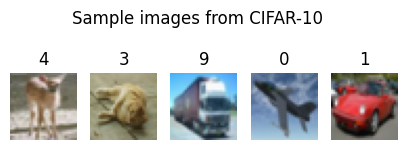

In [3]:
def cifar10_loaders(batch_size: int = 128, num_workers: int = 2, seed: int = 0):
    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    torch.manual_seed(seed)
    train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
    test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=tfm)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_dl  = DataLoader(test_ds,  batch_size=batch_size*2, shuffle=True, num_workers=num_workers)
    return train_dl, test_dl

# plot a few samples from the dataset
train_dl, test_dl = cifar10_loaders(batch_size=5)
images, labels = next(iter(train_dl))
fig, axes = plt.subplots(1, 5, figsize=(5, 2))
for img, lbl, ax in zip(images, labels, axes):
    img = img.permute(1, 2, 0) * torch.tensor([0.2023, 0.1994, 0.2010]) + torch.tensor([0.4914, 0.4822, 0.4465])  # unnormalize
    ax.imshow(img.numpy())
    ax.set_title(str(lbl.item()))
    ax.axis('off')
plt.suptitle("Sample images from CIFAR-10")
plt.show()

## 3. Model definition

A simple MLP with ReLU activations — the architecture on which PathCond's rescaling symmetry applies.

In [4]:
class FullyConvolutional(nn.Module):
    """
    Fully convolutional architecture for cifar10 datset as described in
    Gitman et al., 'Comparison of Batch Normalization and Weight Normalization
    Algorithms for the Large-scale Image Classification'.
    """

    def __init__(self, bias=False):
        super(FullyConvolutional, self).__init__()
        # first block
        self.conv1 = nn.Conv2d(3, 128, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(128, 128, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(128, 128, 3, 1, 1, bias=bias)
        self.pool1 = nn.MaxPool2d(3, 2, 1)
        # second block
        self.conv4 = nn.Conv2d(128, 256, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(256, 256, 3, 1, 1, bias=bias)
        self.conv6 = nn.Conv2d(256, 256, 3, 1, 1, bias=bias)
        self.pool2 = nn.MaxPool2d(3, 2, 1)
        # third block
        self.conv7 = nn.Conv2d(256, 320, 3, 1, 1, bias=bias)
        self.conv8 = nn.Conv2d(320, 320, 1, 1, 0, bias=bias)
        self.conv9 = nn.Conv2d(320, 10, 1, 1, 0, bias=bias)
        self.pool3 = nn.AvgPool2d(8)
        # relu
        self.relu = nn.ReLU()
        # batch norm
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        # reset parameters
        # self.reset_parameters()

    # def reset_parameters(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d):
    #             nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.bn1(x)
        x = self.pool1(self.relu(x))

        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.conv6(x)
        x = self.bn2(x)
        x = self.pool2(self.relu(x))

        x = self.relu(self.conv7(x))
        x = self.relu(self.conv8(x))
        x = self.conv9(x)
        x = self.pool3(self.relu(x))

        return x.flatten(1)

## 4. Training loop

Both models start from **identical initializations** (same seed). PathCond applies `rescaling_path_cond` only at init. The loss is cross-entropy for the actual classification task.

In [5]:
def train_one_epoch(model, loader, criterion, optimizer, device, fraction: float = 1.0) -> float:
    model.train()
    total_loss = 0.0
    total_samples = 0
    max_batches = int(len(loader) * fraction)
    for i, (x, y) in enumerate(loader):
        if i >= max_batches:
            break
        x, y = x.to(device), y.to(device)
       
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * y.size(0)
        total_samples += y.size(0)

    return total_loss / total_samples

@torch.no_grad()
def evaluate(model, loader, device) -> float:
    model.eval()
    correct = total = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        pred = model(x).argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return correct / total

In [6]:
model_pathcond = FullyConvolutional().to(DEVICE)
model_baseline = FullyConvolutional().to(DEVICE)  # identical init

LR=1e-2
NB_EPOCHS=3

opt_pc   = torch.optim.SGD(model_pathcond.parameters(), lr=LR)
opt_base = torch.optim.SGD(model_baseline.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()



train_dl, test_dl = cifar10_loaders(batch_size=128)

loss_pc,   loss_base   = [], []
acc_pc,    acc_base    = [], []


for epoch in range(NB_EPOCHS):
    # --- PathCond ---
    if epoch == 0:
        rescaling_path_cond(model_pathcond)

    model_pathcond.train()
    opt_pc.zero_grad()
    loss = train_one_epoch(model_pathcond, train_dl, criterion, opt_pc, DEVICE)
    loss_pc.append(loss)

    # --- Baseline ---
    model_baseline.train()
    opt_base.zero_grad()
    loss = train_one_epoch(model_baseline, train_dl, criterion, opt_base, DEVICE)
    loss_base.append(loss)

    if (epoch + 1) % 500 == 0:
        acc_pc_val   = evaluate(model_pathcond, test_dl, DEVICE)
        acc_base_val = evaluate(model_baseline, test_dl, DEVICE)
        print(f"Epoch {epoch+1:5d} | "
              f"Loss PathCond: {loss_pc[-1]:.4f}  Acc: {acc_pc_val:.3f} | "
              f"Loss Baseline: {loss_base[-1]:.4f}  Acc: {acc_base_val:.3f}")

print("\nFinal test accuracy:")
print(f"  PathCond : {evaluate(model_pathcond, test_dl, DEVICE):.4f}")
print(f"  Baseline : {evaluate(model_baseline, test_dl, DEVICE):.4f}")

KeyboardInterrupt: 

## 5. Results

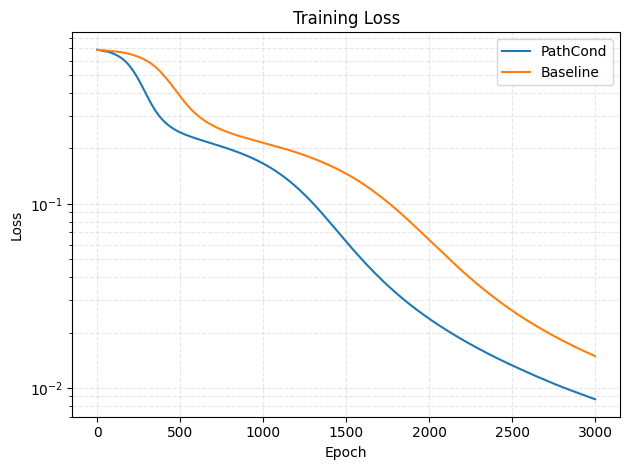

In [ ]:
plt.plot(loss_pc, label="PathCond")
plt.plot(loss_base, label="Baseline")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()